In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import strid
import matplotlib.pyplot as plt
import scipy.signal

# System identification with Covariance driven Stochastic Subspace Identification

This notebook shows how `strid` can be used to obtain the modal properties from measurements of a system subjected to stochastic loading with the Covariance driven Stochastic Subspace Identification (CovSSI) method. 

First we load the data from a shear frame with known modal properties, when we perform the actual system identification.

In [3]:
data = np.load("results/data-stochastic.npz")
y = data["y"]
fs = data["fs"]
true_f = data["true_frequencies"]
true_xi = data["true_damping"]
true_modeshapes = data["true_modeshapes"]

## System identification

Use the measured outputs $y$ to determine the system properties of the shear frame. First we create a subspace identification instance with the input, note that we choose to use the covariance driven method `CovarianceDrivenStochasticSID`, but note that `strid` also has an implementation of the data driven method `DataDrivenStochasticSID`. 

In [4]:
ssid = strid.CovarianceDrivenStochasticSID(y, fs)

We will use a stabilization diagram to determine the physical modes (poles), first we perform system identification from the data with 25 block rows and model order between 5 and 50.

In [5]:
modes = {}
for i, order in enumerate(range(5, 50, 1)):
    A, C, G, R0 = ssid.perform(order, 25)
    modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs) 

and then we plot the identified modes in the stabilization diagram and we pick the stable modes.

<IPython.core.display.Javascript object>


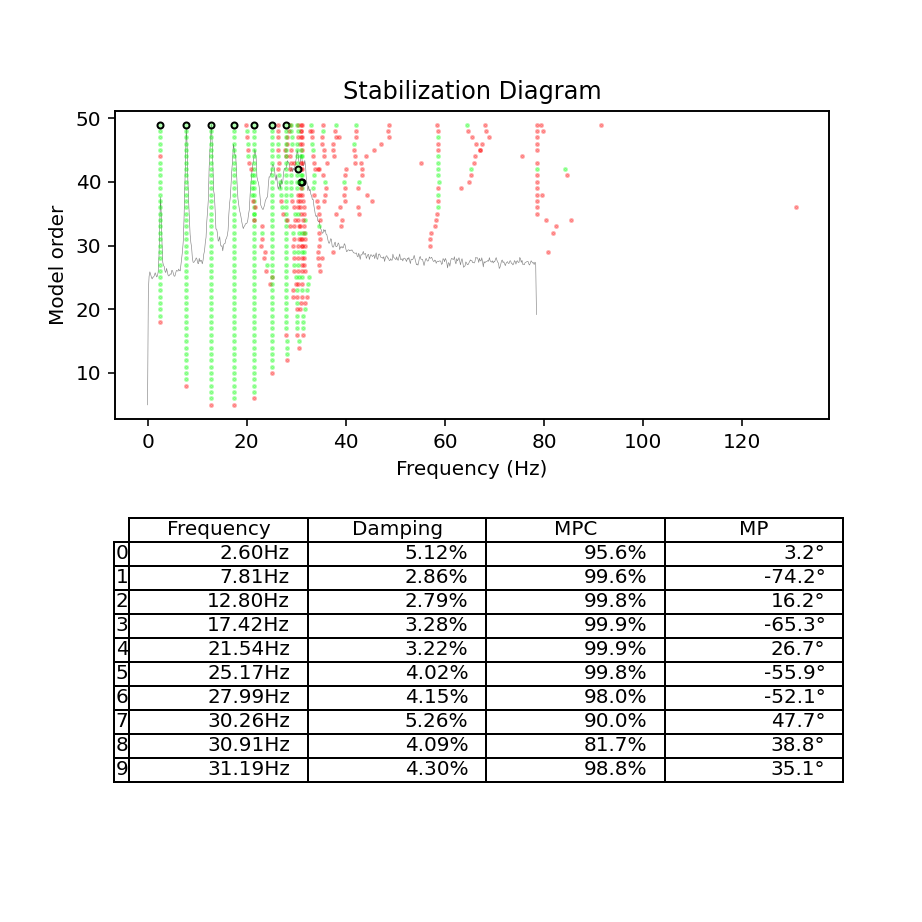

In [6]:
stabdiag = strid.StabilizationDiagram()
stabdiag.plot(modes)

f, psd = ssid.psdy(nperseg=2**10)
stabdiag.axes_psd.semilogy(f, np.trace(np.abs(psd)), color=(0., 0., 0., .5), lw=.3)

Finally, we can access the picked modes from the `picked_modes` property of the stabilization diagram object, see below.

In [9]:
modes = stabdiag.picked_modes

# Comparison between estimated and true modes

Below, we compare the identified modes against the exact solution.

<IPython.core.display.Javascript object>


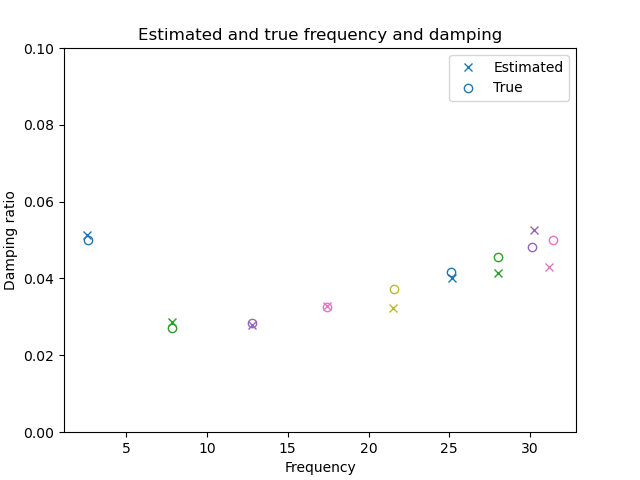

<IPython.core.display.Javascript object>


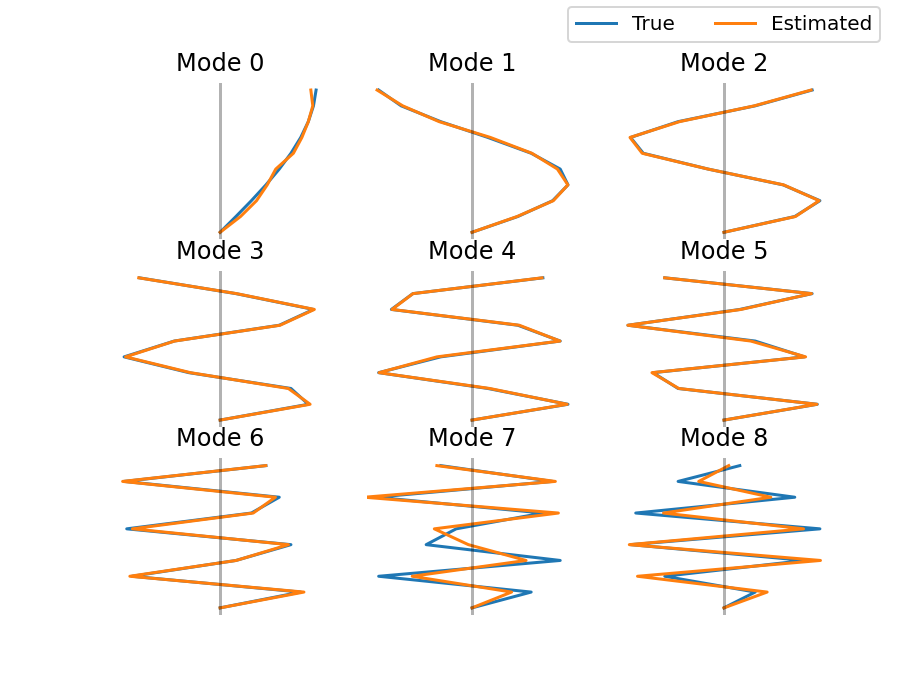

In [10]:
fig = plt.figure("Damping estimate")
axd = fig.add_axes((0.1, 0.1, .8, .8))
axd.set(xlabel='Frequency', ylabel='Damping ratio', title='Estimated and true frequency and damping',
        ylim=(0, .10)
       )
figmodes, axes = plt.subplots(ncols=3, nrows=3, dpi=144)
res = []
for n in range(true_f.size):
    ax = axes.flatten()[n]
    un = true_modeshapes[n]
    fn = true_f[n]
    xin = true_xi[n]
    nmax = np.argmax([strid.modal_assurance_criterion(mode.v, un) for mode in modes])
    mode = modes[nmax]
    
    line, = axd.plot(mode.f, mode.xi, 'x')
    line, = axd.plot(fn, xin, 'o', mec=line.get_color(), mfc=(0, 0, 0, 0))
    
    
    ferr = (mode.f-fn)/fn * 100
    xierr = (mode.xi-xin)/xin*100
    mac = strid.modal_assurance_criterion(un, mode.v)
    res.append([n, ferr, xierr, mac*100,])
    
    
    v_true = np.r_[0., un]
    v = np.r_[0, mode.v]
    v = strid.modal_scale_factor(v, v_true)*v
    z = np.arange(v.size)
    ax.plot(v_true, z, label='True')
    ax.plot(v.real, z, label='Estimated')
    
    if n == 2:
        ax.legend(bbox_to_anchor=(.5, 1.20), loc='lower center', ncol=2)
        axd.legend(['Estimated', 'True'],)
    ax.axvline(0., color=(0, 0, 0, .3))
    
    ax.set_title(f"Mode {n}")
    ax.axis('off')
    ax.set_xlim(-.5, .5)

We can also save the saved modes for further analysis, see below.

In [11]:
import pickle

with open("results/modes.pkl", 'wb') as fout:
    pickle.dump(modes, fout)

See how you can plot and animate the mode shapes identified here with the `strid` package and also other options in the  example [03-visualization-of-mode-shapes](03-visualization-of-mode-shapes.ipynb)